### Pip Install, Init, and Start Pyspark

In [1]:
!pip install kaggle
!pip install pandas
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 955.9 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 1.8 MB/s eta 0:00:00a 0:00:01
  DEPRECATION: kaggle is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for kaggle ... done

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 7.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 14.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━

In [2]:
from pyspark.sql import SparkSession
from pathlib import Path
from pyspark.sql.functions import broadcast
from pyspark.sql.functions import col
import seaborn as sns

In [3]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/02 15:49:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Get the number of cores
num_cores = sc.defaultParallelism

# Get the number of executors
num_executors = sc.getConf().get("spark.executor.instances")

print(num_cores)
print(num_executors)

3
None


In [5]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

### Import Data 

In [6]:
### Uncomment and run these three lines if you haven't downloaded the dataset
# !kaggle datasets download -d guillemservera/global-daily-climate-data
# !unzip global-daily-climate-data.zip
# !rm global-daily-climate-data.zip

In [7]:
# Create DataFrames
data1 = [("Alice", 1), ("Bob", 2), ("Charlie", 3)]
data2 = [("Alice", "Engineer"), ("Bob", "Doctor"), ("David", "Lawyer")]
df1 = spark.createDataFrame(data1, ["Name", "ID"])
df2 = spark.createDataFrame(data2, ["Name", "Profession"])

# Join DataFrames
joined_df = df1.join(df2, "Name")

# Show the result
joined_df.show()

+-----+---+----------+
| Name| ID|Profession|
+-----+---+----------+
|Alice|  1|  Engineer|
|  Bob|  2|    Doctor|
+-----+---+----------+



In [8]:
# A broadcast join is useful when one DataFrame (typically smaller) can fit entirely into 
# memory on each executor node, allowing it to be efficiently broadcasted to all executor nodes for join operations. Here's an example using a broadcast join in PySpark:

# Two DataFrames (employees_df and departments_df) are created from dummy data.
# We perform a broadcast join using the join method on the employees_df. The broadcast function is applied to the departments_df DataFrame, indicating that it should be broadcasted to all executor nodes.
# The join operation is performed based on the "dept_id" column, and the result is stored in the DataFrame broadcast_df.
# Finally, we show the result of the join operation.

In [9]:
# Dummy data for employees and their departments
employees_data = [("Alice", 1), ("Bob", 2), ("Charlie", 1), ("David", 3)]
departments_data = [(1, "HR"), (2, "Engineering"), (3, "Finance")]

# Create DataFrames from the dummy data
employees_df = spark.createDataFrame(employees_data, ["name", "dept_id"])
departments_df = spark.createDataFrame(departments_data, ["dept_id", "dept_name"])

# Perform broadcast join
broadcast_join_df = employees_df.join(broadcast(departments_df),
    on="dept_id",
    how="inner")

# Show the result
broadcast_join_df.show()

+-------+-------+-----------+
|dept_id|   name|  dept_name|
+-------+-------+-----------+
|      1|  Alice|         HR|
|      2|    Bob|Engineering|
|      1|Charlie|         HR|
|      3|  David|    Finance|
+-------+-------+-----------+



In [10]:
# In a shuffle hash join, both DataFrames are partitioned based on the join key, 
# and then shuffled across the network so that rows with the same join key end up in the same partition. This allows Spark to efficiently join the corresponding rows from both DataFrames.

# Two DataFrames (employees_df and departments_df) are created from dummy data.
# We perform a shuffle hash join using the join method on the employees_df. The join operation is performed based on the "dept_id" column, and we specify how="inner" to perform an inner join.
# Spark partitions both DataFrames based on the join key ("dept_id") and shuffles the data across the network so that rows with the same join key end up in the same partition.
# Spark then efficiently joins the corresponding rows from both DataFrames based on the join key.
# Finally, we show the result of the join operation.

# If a broadcast hash join can be used (by the broadcast hint or by total size of a relation), Spark SQL chooses it over other joins (see JoinSelection execution planning strategy).

# Shuffle Hash Join:

# Size of Datasets: Shuffle hash joins are typically more efficient when one or both of the datasets being joined are small enough to fit entirely in memory on each executor node. If one dataset is small enough to be broadcasted, a shuffle hash join can be more efficient.
# Data Distribution: Shuffle hash joins work well when the data is evenly distributed across partitions and the join keys have high cardinality. In this case, the shuffle operation redistributes the data across partitions based on the hash of the join key, which can lead to more balanced partition sizes.
# Memory Usage: Shuffle hash joins are less memory-intensive compared to sort merge joins, as they don't require sorting of data. This can be advantageous when memory resources are limited.
# Sort Merge Join:

# Size of Datasets: Sort merge joins are generally more suitable for joining large datasets that cannot fit entirely in memory on each executor node. They involve sorting the data, which can be memory-intensive, but they can handle larger datasets more efficiently than shuffle hash joins in many cases.
# Data Distribution: Sort merge joins can handle skewed data distributions and low cardinality join keys more effectively than shuffle hash joins. They don't rely on hashing and shuffling data across partitions, so they can handle data skewness without causing performance issues.
# Memory Usage: Sort merge joins are more memory-intensive compared to shuffle hash joins because they involve sorting large datasets. They may require more memory resources, so it's important to ensure that sufficient memory is available on the cluster.


In [11]:
spark.conf.set("spark.sql.join.preferSortMergeJoin", "false")

# Dummy data for employees and their departments
employees_data = [("Alice", 1), ("Bob", 2), ("Charlie", 1), ("David", 3)]
departments_data = [(1, "HR"), (2, "Engineering"), (3, "Finance")]

# Create DataFrames from the dummy data
employees_df = spark.createDataFrame(employees_data, ["name", "dept_id"])
departments_df = spark.createDataFrame(departments_data, ["dept_id", "dept_name"])

# Repartition DataFrames based on the join key
employees_repartitioned = employees_df.repartition("dept_id")
departments_repartitioned = departments_df.repartition("dept_id")

# Perform shuffle hash join
shuffle_hash_join_df = employees_repartitioned.join(
    departments_repartitioned.hint("SHUFFLE_HASH"),
    on="dept_id",
    how="inner"
)

# Show the result
shuffle_hash_join_df.show()

+-------+-------+-----------+
|dept_id|   name|  dept_name|
+-------+-------+-----------+
|      1|  Alice|         HR|
|      2|    Bob|Engineering|
|      1|Charlie|         HR|
|      3|  David|    Finance|
+-------+-------+-----------+



In [12]:
### Sort merge join is typically used when joining large datasets that cannot fit into memory on each executor node. 
### It efficiently handles large datasets by sorting them and then merging them together based on the join key.

# Two DataFrames (employees_df and departments_df) are created from dummy data.
# We perform a sort merge join using the join method on the employees_df. The join operation is performed based on the "dept_id" column, and we specify how="inner" to perform an inner join.
# Spark sorts both DataFrames based on the join key ("dept_id") and then merges them together.
# Finally, we show the result of the join operation.

In [13]:
spark.conf.set("spark.sql.join.preferSortMergeJoin", "true")

# Dummy data for employees and their departments
employees_data = [("Alice", 1), ("Bob", 2), ("Charlie", 1), ("David", 3)]
departments_data = [(1, "HR"), (2, "Engineering"), (3, "Finance")]

# Create DataFrames from the dummy data
employees_df = spark.createDataFrame(employees_data, ["name", "dept_id"])
departments_df = spark.createDataFrame(departments_data, ["dept_id", "dept_name"])

# Perform sort merge join
sort_merge_join_df = employees_df.join(
    departments_df,
    on="dept_id",
    how="inner"
)

# Show the result
sort_merge_join_df.show()

+-------+-------+-----------+
|dept_id|   name|  dept_name|
+-------+-------+-----------+
|      1|  Alice|         HR|
|      1|Charlie|         HR|
|      2|    Bob|Engineering|
|      3|  David|    Finance|
+-------+-------+-----------+



#### Create df1

In [14]:
# df = spark.read.parquet('daily_weather.parquet')
dw_df = spark.read.parquet('*.parquet')

In [15]:
### Both of these trigger OOM
# dw_df.toPandas().show()
# dw_df.collect()

In [16]:
dw_df.show(1, truncate=False, vertical=True)

-RECORD 0-------------------------------------
 station_id             | 41515               
 city_name              | Asadabad            
 date                   | 1957-07-01 00:00:00 
 season                 | Summer              
 avg_temp_c             | 27.0                
 min_temp_c             | 21.1                
 max_temp_c             | 35.6                
 precipitation_mm       | 0.0                 
 snow_depth_mm          | NULL                
 avg_wind_dir_deg       | NULL                
 avg_wind_speed_kmh     | NULL                
 peak_wind_gust_kmh     | NULL                
 avg_sea_level_pres_hpa | NULL                
 sunshine_total_min     | NULL                
 __index_level_0__      | 0                   
only showing top 1 row



In [17]:
dw_df = dw_df.select(*(col(x).alias(x + '_df1') for x in dw_df.columns))


In [18]:
dw_df.createOrReplaceTempView("dw_df")

In [19]:
spark.sql("""SELECT * FROM dw_df LIMIT 2""").show(2)

+--------------+-------------+-------------------+----------+--------------+--------------+--------------+--------------------+-----------------+--------------------+----------------------+----------------------+--------------------------+----------------------+---------------------+
|station_id_df1|city_name_df1|           date_df1|season_df1|avg_temp_c_df1|min_temp_c_df1|max_temp_c_df1|precipitation_mm_df1|snow_depth_mm_df1|avg_wind_dir_deg_df1|avg_wind_speed_kmh_df1|peak_wind_gust_kmh_df1|avg_sea_level_pres_hpa_df1|sunshine_total_min_df1|__index_level_0___df1|
+--------------+-------------+-------------------+----------+--------------+--------------+--------------+--------------------+-----------------+--------------------+----------------------+----------------------+--------------------------+----------------------+---------------------+
|         41515|     Asadabad|1957-07-01 00:00:00|    Summer|          27.0|          21.1|          35.6|                 0.0|             NULL|

#### Create df2

In [20]:
cities_df = spark.read.csv('cities.csv', inferSchema=True, header=True)
cities_df = cities_df.select(*(col(x).alias(x + '_df2') for x in cities_df.columns))
cities_df.createOrReplaceTempView("cities_df")

In [21]:
spark.sql("""SELECT * FROM cities_df LIMIT 2""").show(2)

+--------------+-------------+-----------+----------+--------+--------+-------------+-------------+
|station_id_df2|city_name_df2|country_df2| state_df2|iso2_df2|iso3_df2| latitude_df2|longitude_df2|
+--------------+-------------+-----------+----------+--------+--------+-------------+-------------+
|         41515|     Asadabad|Afghanistan|     Kunar|      AF|     AFG|34.8660000397|71.1500045859|
|         38954|     Fayzabad|Afghanistan|Badakhshan|      AF|     AFG|37.1297607616|70.5792471913|
+--------------+-------------+-----------+----------+--------+--------+-------------+-------------+



In [22]:
cities_df.show()

+--------------+------------------+-----------+------------------+--------+--------+-------------+--------------+
|station_id_df2|     city_name_df2|country_df2|         state_df2|iso2_df2|iso3_df2| latitude_df2| longitude_df2|
+--------------+------------------+-----------+------------------+--------+--------+-------------+--------------+
|         41515|          Asadabad|Afghanistan|             Kunar|      AF|     AFG|34.8660000397| 71.1500045859|
|         38954|          Fayzabad|Afghanistan|        Badakhshan|      AF|     AFG|37.1297607616| 70.5792471913|
|         41560|         Jalalabad|Afghanistan|         Nangarhar|      AF|     AFG|34.4415269155| 70.4361034738|
|         38947|            Kunduz|Afghanistan|            Kunduz|      AF|     AFG|36.7279506623| 68.8725296619|
|         38987|        Qala i Naw|Afghanistan|           Badghis|      AF|     AFG| 34.983000131| 63.1332996367|
|         38915|        Sheberghan|Afghanistan|           Jawzjan|      AF|     AFG|36.6

### Combine the df's

In [23]:
j_df = dw_df.join(cities_df, col('city_name_df1') == col('city_name_df2'))

In [24]:
j_df.show(2)

+--------------+-------------+-------------------+----------+--------------+--------------+--------------+--------------------+-----------------+--------------------+----------------------+----------------------+--------------------------+----------------------+---------------------+--------------+-------------+-----------+---------+--------+--------+-------------+-------------+
|station_id_df1|city_name_df1|           date_df1|season_df1|avg_temp_c_df1|min_temp_c_df1|max_temp_c_df1|precipitation_mm_df1|snow_depth_mm_df1|avg_wind_dir_deg_df1|avg_wind_speed_kmh_df1|peak_wind_gust_kmh_df1|avg_sea_level_pres_hpa_df1|sunshine_total_min_df1|__index_level_0___df1|station_id_df2|city_name_df2|country_df2|state_df2|iso2_df2|iso3_df2| latitude_df2|longitude_df2|
+--------------+-------------+-------------------+----------+--------------+--------------+--------------+--------------------+-----------------+--------------------+----------------------+----------------------+------------------------

In [25]:
j_df.createOrReplaceTempView("j_df")

In [26]:
spark.sql("SELECT * FROM j_df WHERE j_df.station_id_df1 =41515").count()

9572

### Plot

In [27]:
asadabad_df = spark.sql("SELECT * FROM j_df WHERE j_df.station_id_df1 =41515").toPandas() # Convert PySpark DataFrame to Pandas DataFrame

In [28]:
asadabad_df.columns

Index(['station_id_df1', 'city_name_df1', 'date_df1', 'season_df1',
       'avg_temp_c_df1', 'min_temp_c_df1', 'max_temp_c_df1',
       'precipitation_mm_df1', 'snow_depth_mm_df1', 'avg_wind_dir_deg_df1',
       'avg_wind_speed_kmh_df1', 'peak_wind_gust_kmh_df1',
       'avg_sea_level_pres_hpa_df1', 'sunshine_total_min_df1',
       '__index_level_0___df1', 'station_id_df2', 'city_name_df2',
       'country_df2', 'state_df2', 'iso2_df2', 'iso3_df2', 'latitude_df2',
       'longitude_df2'],
      dtype='object')

<Axes: xlabel='date_df1', ylabel='avg_temp_c_df1'>

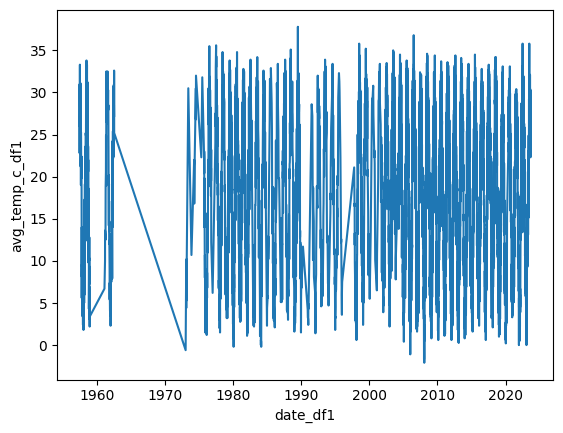

In [29]:
sns.lineplot(data=asadabad_df, x="date_df1", y="avg_temp_c_df1")